In [ ]:
print("Need to download the .nc files via NCSS at:","\n","http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_YYYMMDD_FFFF.grib2/dataset.html")
print("Example:","\n","http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20190910_0000.grib2/dataset.html")



# Cross Section Analysis


The MetPy function `metpy.interpolate.cross_section` can obtain a cross-sectional slice through
gridded data.



In [1]:
from metpy.plots import ctables
mycmap = ctables.registry.get_colortable("NWSReflectivity")

/Users/chowdahead/anaconda3/lib/python3.7/site-packages/distributed/utils.py:139: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
#import pygrib as pg
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
# Importing Datetime Libraries
from datetime import datetime, timedelta
from netCDF4 import num2date
from netCDF4 import Dataset
from matplotlib import patheffects
#import Hi_Lo
import glob, re

In [3]:
from copy import copy

%matplotlib inline
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as sgeom

In [4]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

# PV will be difficult because unlike the other variables, it doens't have a vertical coordinate like isobaric4, or something....

In [5]:
# Set the font 
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

In [43]:
def Var_Cross(Variable,Year,Month,Day,Step,start,end,Radar=False,inset=False,Grids=False,
              inset_dims=None,Extent=None,Data=None,File=None):
    
    
    
    # Define the figure object and primary axes
    fig = plt.figure(1, figsize=(16., 9.))
    ax = plt.axes()

    if Data !=None:
        data = Data
    
    if File !=None:
        data = xr.open_dataset(File)    
        data = data.metpy.parse_cf().squeeze()
        
    if Variable == "Pressure_potential_vorticity_surface":
        Variable = "Pressure_potential_vorticity_surface2"
        var_levs = np.arange(0,3e-06,2e-06)
        print("AHHHHHHH")
        iso_lev = "vert_levs"
        my_cmap = "jet_r"
    
    if Variable == 'Relative_humidity_isobaric':
        var_levs = np.arange(0,120,1)
        iso_lev = 'isobaric'
        my_cmap = "BrBG"
    
    if Variable == 'Temperature_isobaric':
        var_levs = np.arange(200, 330, 5)
        iso_lev = 'isobaric4'
        my_cmap = "nipy_spectral"
        
    if Variable == 'Vertical_velocity_pressure_isobaric':
        var_levs = 30
        iso_lev = 'isobaric6'
        my_cmap = 'PuOr_r'
    
    var_dict = {'Temperature_isobaric':"Temp",'Relative_humidity_isobaric':"RH",
                'Vertical_velocity_pressure_isobaric':"Omega",
               "Pressure_potential_vorticity_surface2":"PV"}
    
    
    
    
    
    
    cross = cross_section(data, start, end)
    cross.set_coords(('lat', 'lon'), True)
    #print(cross['isobaric'])
    temperature, pressure = xr.broadcast(cross['Temperature_isobaric'],cross['isobaric4'])

    theta = mpcalc.potential_temperature(pressure, temperature)
    #rh = mpcalc.relative_humidity_from_specific_humidity(specific_humidity, temperature, pressure)

    # These calculations return unit arrays, so put those back into DataArrays in our Dataset
    cross['Potential_temperature'] = xr.DataArray(theta,
                                                  coords=temperature.coords,
                                                  dims=temperature.dims,
                                                  attrs={'units': theta.units})
    #cross['Relative_humidity'] = xr.DataArray(rh,
    #                                          coords=specific_humidity.coords,
    #                                          dims=specific_humidity.dims,
    #                                          attrs={'units': rh.units})

    cross['u-component_of_wind_isobaric'].metpy.convert_units('knots')
    cross['v-component_of_wind_isobaric'].metpy.convert_units('knots')
    cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(cross['u-component_of_wind_isobaric'],
                                                                       cross['v-component_of_wind_isobaric'])
    #cross['dew'] =  xr.broadcast(cross['Geopotential_height_potential_vorticity_surface'])
    #print(cross)


    # Plot potential temperature using contour, with some custom labeling
    #theta_contour = ax.contour(lons, cross['isobaric'], cross['Potential_temperature'][0,:,:],
    #                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
    
    print(iso_lev)
    if Variable == "Pressure_potential_vorticity_surface2":
        #contour = ax.scatter(cross['lon'], cross[iso_lev], cross[Variable][Step,:],
        #                    cmap=my_cmap,alpha=0.7)
        contour = ax.contourf(cross['lon'], cross[iso_lev], cross[Variable][Step,:],
                            cmap=my_cmap,levels=var_levs,alpha=0.7)
        
    else:
        contour = ax.contourf(cross['lon'], cross[iso_lev], cross[Variable][Step,:],
                            cmap=my_cmap,levels=var_levs,alpha=0.7)
        cbar = plt.colorbar(contour, orientation='vertical',pad=0.004)#,cax=cbaxes)
    
    #'isobaric4'
    theta_contour = ax.contour(cross['lon'], cross['isobaric4'], cross['Potential_temperature'][Step,:,:],
                               levels=np.arange(250, 850, 3), colors='k', linewidths=2)


    # Colorbar Axis Placement (under figure)
    #colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]
    #cbaxes = fig.add_axes(colorbar_axis)


    # Plot winds using the axes interface directly, with some custom indexing to make the barbs
    # less crowded
    wind_slc_vert = list(range(0, 19, 2)) + list(range(19, 29))
    wind_slc_horz = slice(5, 100, 5)
    #ax.barbs(cross['lon'][wind_slc_horz], cross['isobaric'][wind_slc_vert],
    #         cross['t_wind'][Step,:,:][wind_slc_vert, wind_slc_horz],
    #         cross['n_wind'][Step,:,:][wind_slc_vert, wind_slc_horz], color='b')

    # Adjust the y-axis to be logarithmic
    #ax.set_yscale('symlog')
    plt.yscale('log')
    #ax.set_yticklabels(np.arange(1000, 50, -100))
    #ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
    ax.set_ylim(cross['isobaric'].max(), cross['isobaric'][10])


    if inset == True:
    ##############################################################################################################
    # Insert
    ##############################################################################################################

        # Define the CRS and inset axes
        data_crs = data[Variable].metpy.cartopy_crs
        print(data_crs)
        #4-tuple of floats *rect* = ``[left, bottom, width, height]
        if inset_dims !=None:
            ax_inset = plt.axes(inset_dims, projection=ccrs.LambertConformal())
        else:

            ax_inset = plt.axes((0.02, 0.58, 0.23, 0.2), projection=ccrs.PlateCarree())
        #ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

        plot_proj = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)
        if Grids == True:
            # *must* call draw in order to get the axis boundary used to add ticks:
            fig.canvas.draw()

            # Define gridline locations and draw the lines using cartopy's built-in gridliner:
            xticks = [np.arange(-180,180)]
            yticks = [np.arange(0,90)]
            ax_inset.gridlines(xlocs=xticks, ylocs=yticks)

            # Label the end-points of the gridlines using the custom tick makers:
            ax_inset.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
            ax_inset.yaxis.set_major_formatter(LATITUDE_FORMATTER)
            #lambert_xticks(ax, xticks)
            #lambert_yticks(ax, yticks)

            #gl = ax_inset.gridlines(draw_labels=True,crs=ccrs.LambertConformal())
            #gl.xlabels_top = gl.ylabels_right = False
            #gl.xformatter = LONGITUDE_FORMATTER
            #gl.yformatter = LATITUDE_FORMATTER
            
            
            # Plot geopotential height at 500 hPa using xarray's contour wrapper
            ax_inset.contour(data['lon'], data["lat"], data['Geopotential_height_isobaric'][Step,21,:,:],
                             levels=np.arange(5100, 6000, 40), colors='k',transform=data_crs,alpha=0.8)



            # Plot the path of the cross section
            endpoints = data_crs.transform_points(ccrs.LambertConformal(),
                            *np.vstack([start, end])) #

            #print(endpoints)
            #print(cross['lon'][0],cross['lon'][-1],cross['lat'][-1],cross['lat'][0])

            ax_inset.scatter(cross['lon'][0],cross['lat'][0], c='r', zorder=15,transform=data_crs,marker='$S$',s=50)
            ax_inset.scatter(cross['lon'][-1],cross['lat'][-1], c='r', zorder=15,transform=data_crs,marker='$E$',s=50)
            #ax_inset.scatter(259.5,37.25, c='b', zorder=1,transform=data_crs)
            ax_inset.plot(cross['lon'], cross['lat'], c='r', zorder=2,transform=data_crs)

            # Add geographic features
            ax_inset.coastlines()
            ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='b', alpha=0.8, zorder=0)

            #extent = [-130,-60,20,52]
            #extent = [start[1]+10,end[1]-10,start[0]-5,end[0]+5]
            if Extent !=None:
                extent = Extent
            else:
                extent = [start[1]+10,end[1]-15,start[0]-10,end[0]+15]
            ax_inset.set_extent(extent,ccrs.PlateCarree())

    if Radar == True:
        from siphon.catalog import TDSCatalog
        top_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
        ref = top_cat.catalog_refs['Radar Data']

        new_cat = ref.follow()
        model = new_cat.catalog_refs[4]
        gfs_cat = model.follow()

        ds = gfs_cat.datasets[0]
        subset = ds.subset()
        query_data = subset.query()

        from datetime import datetime, timedelta
        now = datetime(Year,Month,Day,Step*3,0)
        query_data.accept('netcdf4')
        query_data.time(now)
        query_data.variables('Base_reflectivity_surface_layer').add_lonlat()

        radar_data = subset.get_data(query_data)

        time = radar_data.variables['time']
        lon = radar_data.variables['lon']
        lat = radar_data.variables['lat']
        dtime = num2date(time[:],time.units)
        X = radar_data.variables['x'][:]
        Y = radar_data.variables['y'][:]

        Time = dtime[0].strftime('%Y-%m-%d %H:%MZ')
        reflec_data = radar_data.variables['Base_reflectivity_surface_layer']
        reflec = radar_data.variables['Base_reflectivity_surface_layer'][:]
        reflec = np.ma.masked_where(reflec < 9,reflec)

        RADAR_levs = np.arange(0,75,1)
    
        cs = ax_inset.pcolormesh(lon[:], lat[:], reflec[0,:,:], cmap=mycmap,transform=plot_proj,vmin=0, vmax=75)
        #cbar = plt.colorbar(cs, orientation='vertical',pad=0.005,aspect=50)
        text_time = ax_inset.text(.995, 0.01, 
                    Time,
                    horizontalalignment='right', transform=ax_inset.transAxes,
                    color='w', fontsize=12, weight='bold')

        text_time2 = ax_inset.text(0.005, 0.01, 
                        "NWS Radar (dbz) & 500mb Heights",
                        horizontalalignment='left', transform=ax_inset.transAxes,
                        color='w', fontsize=12, weight='bold')

        outline_effect = [patheffects.withStroke(linewidth=5, foreground='k')]
        text_time.set_path_effects(outline_effect)
        text_time2.set_path_effects(outline_effect)
    



    #Hi_Lo.plot_maxmin_points(ax_inset,data['lon'], data['lat'], data['MSLP_Eta_model_reduction_msl']/100., 'max', 
    #                         50, symbol='H', color='b',  transform=data_crs)

    #Hi_Lo.plot_maxmin_points(ax_inset,data['lon'], data['lat'], data['MSLP_Eta_model_reduction_msl']/100., 'min', 
    #                         25, symbol='L', color='r', transform=data_crs)

        # Set the titles and axes labels
    #ax_inset.set_title('NWS Radar (dbz) and 500mb Heights')
    #ax.set_title('NARR Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
    #             'Potential Temperature (K), Tangential/Normal Winds (knots), '
    #             'Relative Humidity (dimensionless)\n'
    #             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
    #                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H:%MZ').item()))
    ax.set_ylabel('Pressure (Pa)')
    ax.set_xlabel('Longitude (degrees east)')

    time = data.variables["time2"]
    print(time.values)

    #type(time.values)
    time.values.tolist()
    time.values[Step].astype('datetime64[s]')
    TIME = time.values[Step].astype('datetime64[s]').tolist()
    #type(TIME)
    file_time = '{0:%Y_%m_%d_%H:%MZ}'.format(TIME)

    ax.set_title("GFS: Theta and "+var_dict[Variable]+" Cross Section "+"{0:%Y-%m-%d %H:%MZ}".format(TIME))

    fig.savefig("/Users/chowdahead/Desktop/"+var_dict[Variable]+"_cross"+file_time.replace(":","")+"Z.png",bbox_inches='tight',dpi=120)
    plt.close(fig)
    #plt.show()

In [7]:
File = 'GFS_Global_0p25deg_20190916_1200.grib2.nc'
#File = 'GFS_Global_0p5deg_20190522_0000.grib2.nc'
File = "GFS_Global_0p25deg_20190916_1200.grib2.nc"
data = xr.open_dataset(File)

data = data.metpy.parse_cf().squeeze()

#for var in data:
#    print(var)
#type(data)
#data

In [122]:
now = datetime.utcnow()
#now = datetime(2019,4,10,0,0)
today_day = int('{0:%d}'.format(now))
today_year = int('{0:%Y}'.format(now))
today_month = int('{0:%m}'.format(now))
init_hour = "0000"
print(today_day,today_year,today_month)


16 2020 1


In [123]:
# System Tools
import os

import numpy

# Importing Datetime Libraries
from datetime import datetime, timedelta

# CartoPy Map Plotting Libraires
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Numerical and Scientific Libraries
import numpy as np
from scipy.ndimage import gaussian_filter

# Accessing Data from XLM Catalog via Siphon Libraries
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

# MetPy Libraries
from metpy.plots import add_metpy_logo

# NetCDF Libraries
from netCDF4 import num2date

# Matplotlib Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib import patheffects

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [124]:
# Thanks to the crew over at Metpy for this handy little function
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [125]:
precip_name = "Categorical_Rain_surface_Mixed_intervals_Average"
pv_name = "Pressure_potential_vorticity_surface"

cat_1 = "http://thredds-jetstream.unidata.ucar.edu/thredds/catalog/grib/NCEP/"
cat_2 = f"GFS/CONUS_20km/GFS_CONUS_20km_{today_year}{today_month:02d}{today_day:02d}_{init_hour}.grib2/catalog.xml"
gfs = TDSCatalog(cat_1+cat_2)

dataset = list(gfs.datasets.values())[0]
#print(dataset.access_urls)

# Create NCSS object to access the NetcdfSubset
ncss = NCSS(dataset.access_urls['NetcdfSubset'])

# get current date and time
#now = forecast_times[0]
now = datetime(today_year,today_month,today_day,0,0)
# define time range you want the data for
start = now
print(start)
delta_t = 48
end = now + timedelta(hours=delta_t)

query = ncss.query()
query.time_range(start, end)
query.lonlat_box(north=60, south=20, east=310, west=230)
query.accept('netcdf4')
query.variables(pv_name).add_lonlat()


# Request data for the variables you want to use
data = ncss.get_data(query)

# Pull out the lat and lon data
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]

# Get time into a datetime object
time_var = data.variables[find_time_var(data.variables[pv_name])]
time_var = num2date(time_var[:], time_var.units).tolist()
time_strings = [t.strftime('%m/%d %H:%M') for t in time_var]

# Combine 1D latitude and longitudes into a 2D grid of locations
#lon_2d, lat_2d = np.meshgrid(lons, lats)

time_var = data.variables[find_time_var(data.variables[pv_name])]
time_final = num2date(time_var[:].squeeze(), time_var.units)




pv = data.variables[pv_name][:]
Unit = data.variables[pv_name].units
#Unit = Unit.replace("."," ").replace("-2","^{-2}").replace("-1","^{-1}")
Unit = "$"+Unit+"$"
print(Unit)
print("done.")

2020-01-16 00:00:00
$Pa$
done.


In [9]:
list(data.variables)

['time2',
 'lat',
 'lon',
 'crs',
 'MSLP_Eta_model_reduction_msl',
 'LatLon_Projection',
 'isobaric',
 'Relative_humidity_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric',
 'isobaric4',
 'Geopotential_height_isobaric',
 'Temperature_isobaric',
 'isobaric6',
 'Vertical_velocity_pressure_isobaric',
 'potential_vorticity_surface',
 'Pressure_potential_vorticity_surface']

In [10]:
time = data.variables["time2"][:]
#print(time.values,len(time.values))
print(time)

<xarray.IndexVariable 'time2' (time2: 2)>
array(['2019-09-16T15:00:00.000000000', '2019-09-16T18:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    standard_name:        time
    long_name:            GRIB forecast or observation time
    _CoordinateAxisType:  Time


In [11]:
vert_levs = np.arange(20000,30000,1)

In [12]:
data["Pressure_potential_vorticity_surface"][:,1,:,:].shape

(2, 141, 241)

In [133]:
print(data,"ahhhh\n",rootgrp)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Analysis_or_forecast_generating_process_identifier_defined_by_originating_centre: Analysis from GFS (Global Forecast System)
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/GFS/CONUS_20km/GFS_CONUS_20km_20200116_0000.grib2.ncx3#LambertConformal_257X369-40p69N-100p4W; Translation Date = 2020-01-16T23:47:49.013Z
    geospatial_lat_min: 19.913055968940412
    geospatial_lat_max: 57.335950219792934
    geospatial_lon_min: -145.74526112705217
    geospatial_lon_max: -49.20529767978462
    dimension

In [ ]:
from netCDF4 import Dataset
import numpy as np

data = Dataset('data.nc', 'w', format='NETCDF4_CLASSIC')

data.createDimension('z', 67)
data.createDimension('x', 288)
data.createDimension('y', 288)
# 'z' has to be a tuple
nz = data.createVariable('zn', np.float32, ('z',))
nx = data.createVariable('xn', np.float32, ('x',))
nx = data.createVariable('yn', np.float32, ('y',))

N = data.createVariable('N', np.float32, ('z','x','y'))

In [140]:
rootgrp = Dataset("test.nc", "w", format="NETCDF4")
rootgrp.close()

rootgrp = Dataset("test.nc", "a")
#fcstgrp = rootgrp.createGroup("forecasts")
#analgrp = rootgrp.createGroup("analyses")
#print(rootgrp.groups)

In [141]:
level = rootgrp.createDimension("level", None)
time = rootgrp.createDimension("time", None)
lat = rootgrp.createDimension("lat", 73)
lon = rootgrp.createDimension("lon", 144)

In [143]:
times = rootgrp.createVariable("time","f8",("time",))
levels = rootgrp.createVariable("level","i4",("level",))
latitudes = rootgrp.createVariable("lat","f4",("lat",))
longitudes = rootgrp.createVariable("lon","f4",("lon",))
# two dimensions unlimited
temp = rootgrp.createVariable("temp","f4",("time","level","lat","lon",))
temp.units = "K"

In [144]:
temp

<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, level, lat, lon)
    units: K
unlimited dimensions: time, level
current shape = (0, 0, 73, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

In [145]:
import numpy
lats =  numpy.arange(-90,91,2.5)
lons =  numpy.arange(-180,180,2.5)
latitudes[:] = lats
longitudes[:] = lons
print("latitudes =\n{}".format(latitudes[:]))

latitudes =
[-90.  -87.5 -85.  -82.5 -80.  -77.5 -75.  -72.5 -70.  -67.5 -65.  -62.5
 -60.  -57.5 -55.  -52.5 -50.  -47.5 -45.  -42.5 -40.  -37.5 -35.  -32.5
 -30.  -27.5 -25.  -22.5 -20.  -17.5 -15.  -12.5 -10.   -7.5  -5.   -2.5
   0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90. ]


In [146]:
nlats = len(rootgrp.dimensions["lat"])
nlons = len(rootgrp.dimensions["lon"])
print("temp shape before adding data = {}".format(temp.shape))

from numpy.random import uniform
#temp[0:1, 0:10, :, :] = uniform(size=(5, 10, nlats, nlons))
lon2d, lat2d = np.meshgrid(lons, lats)
for i in range(0,10):
    temp[0:1, i, :, :] = np.cos(np.deg2rad(lat2d) * 4)*np.cos(np.deg2rad(lat2d) * i) + \
    np.sin(np.deg2rad(lon2d) * 4)*np.cos(np.deg2rad(lat2d) * i)

print("temp shape after adding data = {}".format(temp.shape))

# levels have grown, but no values yet assigned.
print("levels shape after adding pressure data = {}".format(levels.shape))


temp shape before adding data = (0, 0, 73, 144)
temp shape after adding data = (1, 10, 73, 144)
levels shape after adding pressure data = (10,)


In [147]:
levels[:] =  [1000.,850.,700.,500.,300.,250.,200.,150.,100.,50.]

In [110]:
temp.shape

(1, 10, 73, 144)

In [111]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Add Map Features
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_1_states_provinces_lakes',scale='50m', facecolor='none')

country_borders = cfeature.NaturalEarthFeature(category='cultural',
    name='admin_0_countries',scale='50m', facecolor='none')

# Colorbar Axis Placement (under figure)
colorbar_axis = [0.183, 0.09, 0.659, 0.03] # [left, bottom, width, height]

# Lat/Lon Extents [lon0,lon1,lat0,lat1]
extent = [-130., -70, 20., 60.]

In [148]:
i = 0

IndexError: index exceeds dimension bounds

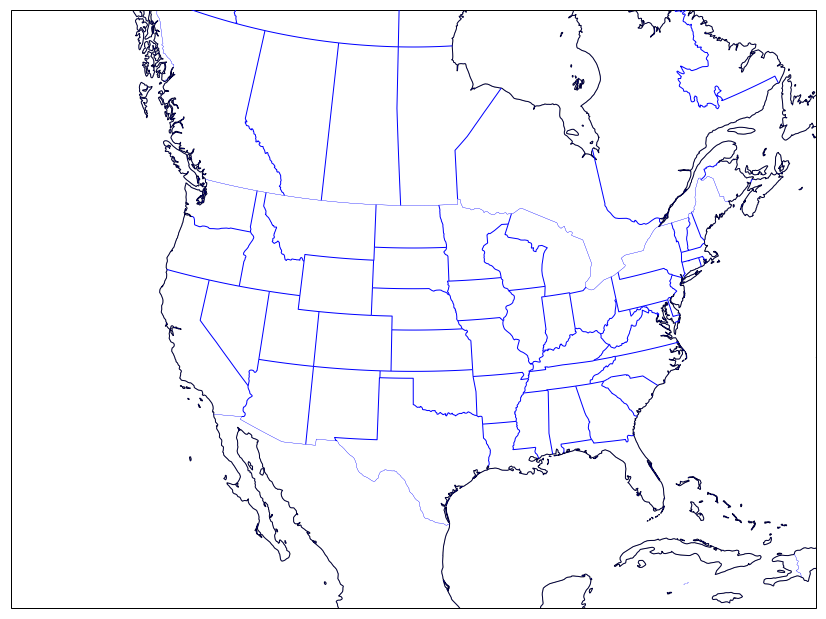

In [159]:

kw_clabels = {'fontsize': 11, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

                                    # Setup Figure
#---------------------------------------------------------------------------------------------------    
fig = plt.figure(figsize=(17., 11.))

#add_metpy_logo(fig, 25, 950, size='small')

                                    # Add the Map 
#---------------------------------------------------------------------------------------------------
ax = plt.subplot(111, projection=plotcrs)

# Set extent and plot map lines
ax.set_extent(extent,datacrs)
    
ax.coastlines(resolution='50m')

                            # Add State/Country Boundaries to Plot
#---------------------------------------------------------------------------------------------------    
state_borders = cfeature.NaturalEarthFeature(
                category='cultural', name='admin_1_states_provinces_lines',
                scale='50m', facecolor='none')
ax.add_feature(state_borders, edgecolor='b', linewidth=1, zorder=3)
    
country_borders = cfeature.NaturalEarthFeature(category='cultural',
                name='admin_0_countries',scale='50m', facecolor='none')
ax.add_feature(country_borders,edgecolor='b',linewidth=0.2)
    
                                            # Precipital Water
#---------------------------------------------------------------------------------------------------
clevs = np.arange(0.00005, 0.0065, 0.00005)
cs2 = ax.contourf(lons, lats, temp[0, i, :, :], 100, cmap='terrain_r',alpha=0.5,transform=datacrs)

plt.savefig(f"/Users/chowdahead/Desktop/ahhh_{i}.png")    
plt.show()
i+=1

In [160]:
i

10

In [19]:


data2 = data["Pressure_potential_vorticity_surface"][:,1,:,:].squeeze()
print(data2.shape)
data2 = np.zeros((len(time),len(vert_levs),len(data["lat"]),len(data["lon"])))
data2.shape
#data2[:] = 2e-06
#time.values

(2, 141, 241)


(2, 10000, 141, 241)

In [ ]:
len(lats)

In [ ]:
data2 = data.

In [ ]:
type(data)

In [15]:
start = (45, -110.0)
end = (35, -97.0)

inset = (0.0255, 0.45, 0.43, 0.43)
extent = [start[1]-5,end[1]+5,start[0]+5,end[0]-5]

print(np.where(data['lon'].values==360+start[1]),np.where(data['lat'].values==end[0]))
print(np.where(data['lon'].values==360+end[1]),np.where(data['lat'].values==start[0]))
lon_start_index = np.where(data['lon'].values==360+start[1])
lon_end_index = np.where(data['lon'].values==360+end[1])
lat_start_index = np.where(data['lat'].values==start[0])
lat_end_index = np.where(data['lat'].values==end[0])
lat_end_index[0][0]
print("Lat start:",lat_start_index[0][0],"end:",lat_end_index[0][0],
      "\nLon start:",lon_start_index[0][0],"end:",lon_end_index[0][0])

(array([80]),) (array([80]),)
(array([132]),) (array([40]),)
Lat start: 40 end: 80 
Lon start: 80 end: 132


In [20]:
%%time
for m in range(0,1):
    for l in range(lat_start_index[0][0],lat_end_index[0][0]-15+1):
        for k in range(lon_start_index[0][0],lon_end_index[0][0]-30+1):
            for j in range(len(vert_levs)): 
                if vert_levs[j] == data["Pressure_potential_vorticity_surface"][m,1,l,k].values.astype(int):
                    print("ahh:",vert_levs[j],m,l,k)
                    data2[m,1,l,k] = 2e-06

ahh: 21842 0 40 93
ahh: 22341 0 40 94
ahh: 22578 0 40 95
ahh: 21796 0 40 96
ahh: 20369 0 40 97
ahh: 20037 0 40 101
ahh: 20130 0 40 102
ahh: 20044 0 41 80
ahh: 20037 0 41 81
ahh: 21621 0 41 93
ahh: 22503 0 41 94
ahh: 23271 0 41 95
ahh: 21301 0 41 96
ahh: 20529 0 41 97
ahh: 20314 0 41 98
ahh: 20236 0 41 101
ahh: 20117 0 41 102
ahh: 20081 0 42 80
ahh: 20223 0 42 81
ahh: 20130 0 42 91
ahh: 21177 0 42 92
ahh: 21977 0 42 93
ahh: 23242 0 42 94
ahh: 22311 0 42 95
ahh: 20919 0 42 96
ahh: 20482 0 42 97
ahh: 20241 0 42 98
ahh: 20124 0 42 99
ahh: 20316 0 42 101
ahh: 20245 0 42 102
ahh: 20588 0 43 80
ahh: 20423 0 43 81
ahh: 21282 0 43 92
ahh: 24159 0 43 94
ahh: 21925 0 43 95
ahh: 20749 0 43 96
ahh: 20412 0 43 97
ahh: 20575 0 43 98
ahh: 20852 0 43 99
ahh: 20180 0 43 100
ahh: 20479 0 43 101
ahh: 20519 0 43 102
ahh: 20810 0 44 80
ahh: 20263 0 44 81
ahh: 22373 0 44 95
ahh: 20861 0 44 96
ahh: 20461 0 44 97
ahh: 20485 0 44 98
ahh: 20593 0 44 99
ahh: 20567 0 44 100
ahh: 20706 0 44 101
ahh: 20661 0 44 102


KeyboardInterrupt: 

In [21]:
data_newcoord = data.assign_coords(vert_levs=vert_levs)
data = data_newcoord.expand_dims('vert_levels')
#print(data.)
print(data)

<xarray.Dataset>
Dimensions:                               (isobaric: 31, isobaric4: 34, isobaric6: 21, lat: 141, lon: 241, potential_vorticity_surface: 2, time2: 2, vert_levels: 1, vert_levs: 10000)
Coordinates:
  * time2                                 (time2) datetime64[ns] 2019-09-16T15:00:00 2019-09-16T18:00:00
  * lat                                   (lat) float32 55.0 54.75 ... 20.0
  * lon                                   (lon) float32 230.0 230.25 ... 290.0
    crs                                   object Projection: latitude_longitude
  * isobaric                              (isobaric) float32 100.0 ... 100000.0
  * isobaric4                             (isobaric4) float32 40.0 ... 100000.0
  * isobaric6                             (isobaric6) float32 10000.0 ... 100000.0
  * potential_vorticity_surface           (potential_vorticity_surface) float32 -2e-06 2e-06
  * vert_levs                             (vert_levs) int64 20000 ... 29999
Dimensions without coordinates: ver

In [22]:
AHHA = xr.DataArray(data2, coords=[time.values,vert_levs, data['lat'],data['lon']], 
             dims=['time2',"vert_levs",'lat','lon'])

In [23]:
data["Pressure_potential_vorticity_surface2"]=(['time2', 'vert_levs', 'lat', 'lon'],  AHHA)
data = data.metpy.parse_cf().squeeze()
print(data)

<xarray.Dataset>
Dimensions:                                (isobaric: 31, isobaric4: 34, isobaric6: 21, lat: 141, lon: 241, potential_vorticity_surface: 2, time2: 2, vert_levs: 10000)
Coordinates:
  * time2                                  (time2) datetime64[ns] 2019-09-16T15:00:00 2019-09-16T18:00:00
  * lat                                    (lat) float32 55.0 54.75 ... 20.0
  * lon                                    (lon) float32 230.0 230.25 ... 290.0
    crs                                    object Projection: latitude_longitude
  * isobaric                               (isobaric) float32 100.0 ... 100000.0
  * isobaric4                              (isobaric4) float32 40.0 ... 100000.0
  * isobaric6                              (isobaric6) float32 10000.0 ... 100000.0
  * potential_vorticity_surface            (potential_vorticity_surface) float32 -2e-06 2e-06
  * vert_levs                              (vert_levs) int64 20000 ... 29999
Data variables:
    MSLP_Eta_model_reduct

In [ ]:
File

In [44]:
%%time

Var_Cross("Pressure_potential_vorticity_surface",
                2020,1,16,0,start,end,Radar=True,inset=True,inset_dims=inset,Extent=extent,Data=data) #Data=data File=File

AHHHHHHH


/Users/chowdahead/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


vert_levs


/Users/chowdahead/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:215: RuntimeWarning: invalid value encountered in less


['2019-09-16T15:00:00.000000000' '2019-09-16T18:00:00.000000000']
CPU times: user 1min 37s, sys: 17.1 s, total: 1min 54s
Wall time: 2min 51s


In [41]:
data['Pressure_potential_vorticity_surface'][0,1,:,:]

<xarray.DataArray 'Pressure_potential_vorticity_surface' (lat: 141, lon: 241)>
array([[23804.244, 24775.443, 24111.443, ..., 23557.844, 23585.043, 23628.244],
       [23641.043, 24439.443, 24788.244, ..., 23255.443, 23164.244, 23116.244],
       [24378.645, 23684.244, 24788.244, ..., 24877.844, 24501.844, 24231.443],
       ...,
       [10367.443, 10092.243,  9577.043, ..., 16324.244, 11804.243, 14389.844],
       [ 9922.643,  9373.843,  9365.843, ..., 14613.844, 14482.644, 14487.443],
       [10071.443, 10053.843, 10081.043, ..., 13695.443, 14201.044, 14490.644]],
      dtype=float32)
Coordinates:
    time2                        datetime64[ns] 2019-09-16T15:00:00
  * lat                          (lat) float32 55.0 54.75 54.5 ... 20.25 20.0
  * lon                          (lon) float32 230.0 230.25 ... 289.75 290.0
    crs                          object Projection: latitude_longitude
    potential_vorticity_surface  float32 2e-06
Attributes:
    long_name:                      Press

In [26]:
data['Vertical_velocity_pressure_isobaric']

<xarray.DataArray 'Vertical_velocity_pressure_isobaric' (time2: 2, isobaric6: 21, lat: 141, lon: 241)>
array([[[[ 0.001969, ...,  0.002569],
         ...,
         [ 0.016569, ..., -0.034631]],

        ...,

        [[ 0.279199, ...,  0.038199],
         ...,
         [ 0.010199, ...,  0.011199]]],


       [[[-0.002404, ..., -0.000604],
         ...,
         [-0.007804, ...,  0.036196]],

        ...,

        [[ 0.031993, ...,  0.024993],
         ...,
         [ 0.030993, ...,  0.077993]]]], dtype=float32)
Coordinates:
  * time2      (time2) datetime64[ns] 2019-09-16T15:00:00 2019-09-16T18:00:00
  * lat        (lat) float32 55.0 54.75 54.5 54.25 ... 20.75 20.5 20.25 20.0
  * lon        (lon) float32 230.0 230.25 230.5 230.75 ... 289.5 289.75 290.0
    crs        object Projection: latitude_longitude
  * isobaric6  (isobaric6) float32 10000.0 15000.0 20000.0 ... 97500.0 100000.0
Attributes:
    long_name:                      Vertical velocity (pressure) @ Isobaric s...
    units: 

In [ ]:
data